#**BISINDO Sign Language Classification using Convolutional Neural Network**
by Faiz Khansa Adrika for Seminar Genap 2020/2021

##Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

##Import the dataset from kaggle

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
os.getcwd()
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/Kaggle'

In [ ]:
#!kaggle datasets download -d riestiyazain/bisindo2

100% 2.77G/2.77G [00:45<00:00, 69.0MB/s]
100% 2.77G/2.77G [00:45<00:00, 64.8MB/s]


In [ ]:
#!cp bisindo2.zip /gdrive/MyDrive/Kaggle

In [ ]:
os.chdir('/gdrive/MyDrive/Kaggle')

In [ ]:
!unzip -q 'bisindo2.zip'
!rm 'bisindo2.zip'

In [ ]:
os.chdir('/content')
print(os.listdir("/gdrive/MyDrive/Kaggle/Bisindo"))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
datadir = '/gdrive/MyDrive/Kaggle/Bisindo'

##Visualization

unique_labels =  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


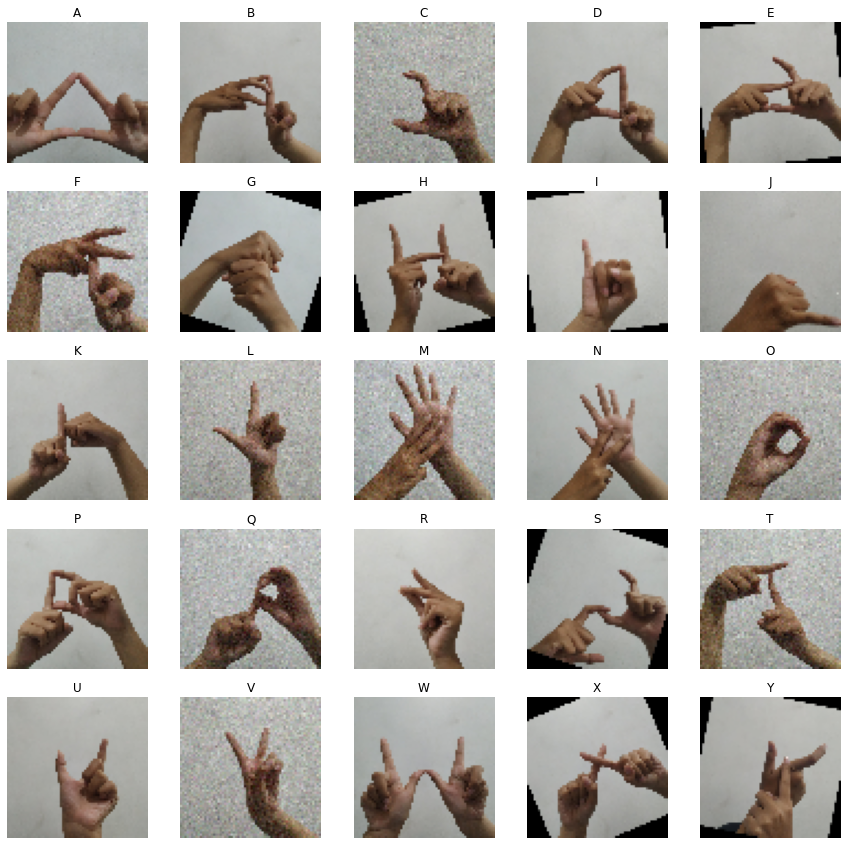

In [ ]:
def load_unique():
    size_img = 64,64 
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(datadir):
        for file in os.listdir(datadir + '/' + folder):
            filepath = datadir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images_for_plot.append(final_img)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 5
col = 5
for i in range(1,(row*col+1)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

##Preprocessing

In [ ]:
def preprocess(image):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
  img = cv2.resize(image, (300,300))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(img,(5,5),0)
  th,_ = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  upperth = th  #upper threshold for the canny edge
  lowerth = 0.4*th #lower threshold for the canny edge
  edges = cv2.Canny(blurred,lowerth,upperth)
  dilate = cv2.dilate(edges,kernel,iterations = 1)
  open = cv2.morphologyEx(dilate, cv2.MORPH_OPEN, kernel)
  return img, blurred, edges, open

###Preprocessing Example

In [ ]:
ex_images = []
ex_titles = ['Original', 'Grayscale', 'Smoothing', 'Canny Edge', 'Opening']
ex_images.append(example_img)
ex_images.append(ex_img)
ex_images.append(ex_blurred)
ex_images.append(ex_edges)
ex_images.append(ex_open)

In [ ]:
preprocess_example = '/gdrive/MyDrive/Kaggle/Bisindo/C/augmented_image_0.jpg'
example_img = cv2.imread(preprocess_example)
ex_img, ex_blurred, ex_edges, ex_open = preprocess(example_img)

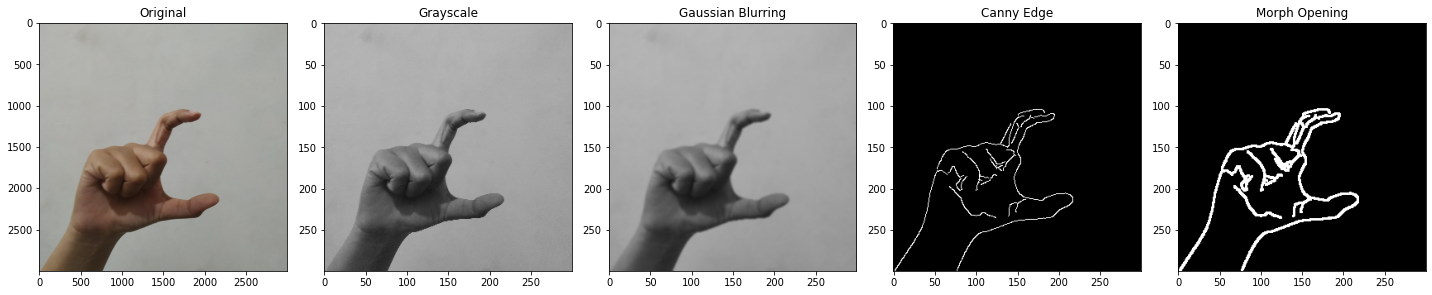

In [ ]:
plt.rcParams["figure.figsize"] = [20, 20]
plt.rcParams["figure.autolayout"] = True
plt.subplot(1, 5, 1)
plt.imshow(cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.subplot(1, 5, 2)
plt.imshow(cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB))
plt.title('Grayscale')
plt.subplot(1, 5, 3)
plt.imshow(cv2.cvtColor(ex_blurred, cv2.COLOR_BGR2RGB))
plt.title('Gaussian Blurring')
plt.subplot(1, 5, 4)
plt.imshow(cv2.cvtColor(ex_edges, cv2.COLOR_BGR2RGB))
plt.title('Canny Edge')
plt.subplot(1, 5, 5)
plt.imshow(cv2.cvtColor(ex_open, cv2.COLOR_BGR2RGB))
plt.title('Morph Opening')
plt.show()

In [ ]:
plt.savefig('Preprocessing.png')

<Figure size 1440x1440 with 0 Axes>

#####plotting for mini report

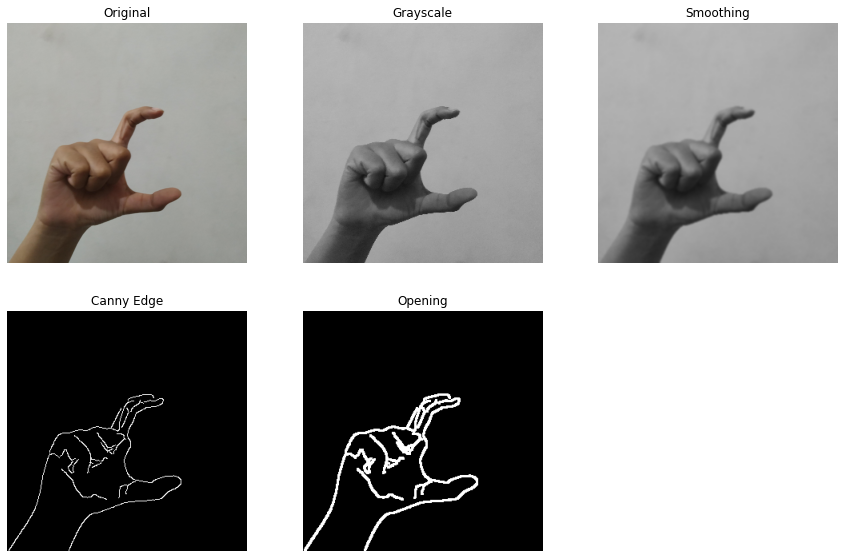

###Data Loading and Splitting

In [ ]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,
               'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25}

def load_data():
    images = []
    labels = []
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(datadir):
        print(folder, end = ' | ')
        for image in os.listdir(datadir + "/" + folder):
            temp_img = cv2.imread(datadir + '/' + folder + '/' + image)
            _,_,_,temp_img = preprocess(temp_img)
            images.append(temp_img)
            labels.append(labels_dict[folder])
    
    images = np.array(images).astype(float)
    
    labels = to_categorical(labels)
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.2)
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, Y_train, Y_test

In [ ]:
X_train, X_test, Y_train, Y_test = load_data()

LOADING DATA FROM : A | B | C | D | E | F | G | H | I | J | K | L | M | N | O | P | Q | R | S | T | U | V | W | X | Y | Z | 
Loaded 2127 images for training, Train data shape = (2127, 300, 300)
Loaded 532 images for testing Test data shape = (532, 300, 300)


In [ ]:
X_train = np.expand_dims(X_train, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(2127, 300, 300, 1)
(532, 300, 300, 1)


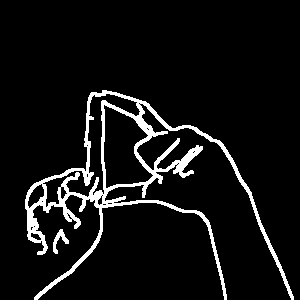

In [ ]:
cv2_imshow(X_train[0])

###Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   height_shift_range=0.2,
                                   width_shift_range=0.2,
                                   zoom_range=0.1,
                                   shear_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow(X_train,
                               Y_train,
                               batch_size = 32)

validation_gen = validation_datagen.flow(X_test,
                                         Y_test,
                                         batch_size=32)

##Modelling

###Defining the callback

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

I only used the Early Stopping above

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.998):
      print("\nReached 99.8% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

###Creating the Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (5,5), activation='relu', input_shape=(300, 300, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 296, 296, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 144, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

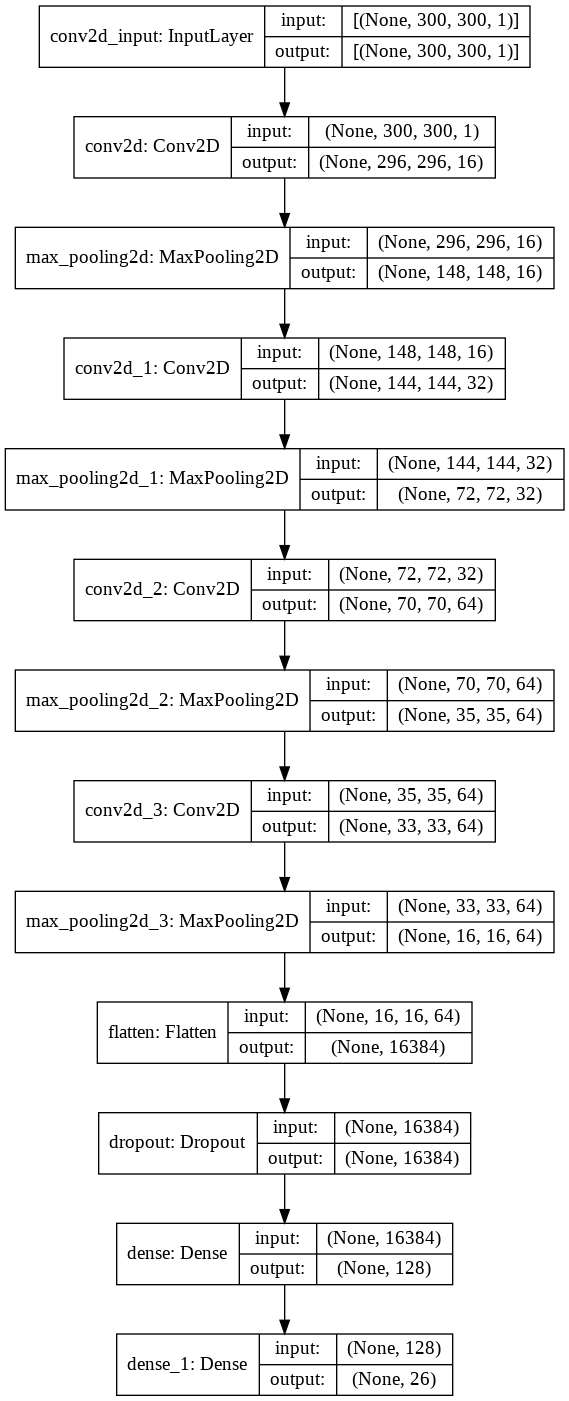

In [ ]:
tf.keras.utils.plot_model(model,
                          to_file="model.png",
                          show_shapes=True,
                          show_dtype=False,
                          show_layer_names=True,
                          rankdir="TB",                          
                          expand_nested=True,
                          dpi=96)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

###Training The Model

In [ ]:
history = model.fit(train_gen, 
                    epochs=100, 
                    validation_data = validation_gen,
                    callbacks = [callback])

Epoch 1/100
67/67 [==============================] - 270s 4s/step - loss: 3.0412 - accuracy: 0.1067 - val_loss: 2.1405 - val_accuracy: 0.3383
Epoch 2/100
67/67 [==============================] - 280s 4s/step - loss: 2.2218 - accuracy: 0.3470 - val_loss: 1.1913 - val_accuracy: 0.6711
Epoch 3/100
67/67 [==============================] - 270s 4s/step - loss: 1.3750 - accuracy: 0.5924 - val_loss: 0.5229 - val_accuracy: 0.8365
Epoch 4/100
67/67 [==============================] - 272s 4s/step - loss: 0.9297 - accuracy: 0.7306 - val_loss: 0.3363 - val_accuracy: 0.8797
Epoch 5/100
67/67 [==============================] - 270s 4s/step - loss: 0.6449 - accuracy: 0.8082 - val_loss: 0.2061 - val_accuracy: 0.9305
Epoch 6/100
67/67 [==============================] - 276s 4s/step - loss: 0.4938 - accuracy: 0.8552 - val_loss: 0.1877 - val_accuracy: 0.9398
Epoch 7/100
67/67 [==============================] - 271s 4s/step - loss: 0.4117 - accuracy: 0.8759 - val_loss: 0.1569 - val_accuracy: 0.9455
Epoch 

###Plotting the History of Accuracy and Loss

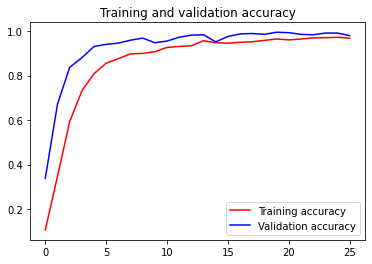

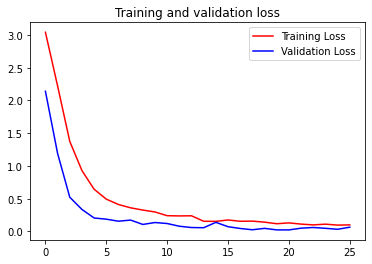

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###Model Testing

In [ ]:
def evaluate_F1(model,Y_test,X_test):
    from sklearn.metrics import f1_score
    y_true = [np.where(r==1)[0][0] for r in Y_test]
    classes = model.predict_classes(X_test)
    return f1_score(y_true,classes,average=None)

In [ ]:
test_images = X_test/255.

####with normalization

In [ ]:
model.evaluate(validation_gen, verbose=1)

17/17 [==============================] - 16s 921ms/step - loss: 0.0656 - accuracy: 0.9793


[0.06558651477098465, 0.9793233275413513]

In [ ]:
evaluate_F1(model,Y_test,test_images)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([1.        , 1.        , 1.        , 0.89655172, 1.        ,
       1.        , 0.97959184, 1.        , 0.86486486, 1.        ,
       0.95652174, 1.        , 1.        , 1.        , 0.87179487,
       0.92682927, 0.93877551, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

####without normalization

In [ ]:
evaluate_metrics = model.evaluate(X_test, Y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

17/17 [==============================] - 15s 884ms/step - loss: 13.2146 - accuracy: 0.9699

Evaluation Accuracy =  96.99% 
Evaluation loss =  13.214581


In [ ]:
evaluate_F1(model,Y_test,X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0.97435897, 1.        , 1.        , 0.85714286, 1.        ,
       1.        , 0.97959184, 1.        , 0.83333333, 1.        ,
       0.9787234 , 0.96774194, 0.91428571, 0.91891892, 0.87179487,
       0.9047619 , 0.95833333, 1.        , 1.        , 1.        ,
       1.        , 0.96969697, 1.        , 1.        , 1.        ,
       1.        ])

##Saving the model

In [ ]:
model.save('Bisindo_model.h5')